In [163]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries

# Eccentric TEOBResumS waveform

In [11]:
# Mass parameters
M1 = 36 # Mo
M2 = 29 # Mo

# Use 22 mode only
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
k = modes_to_k([[2,2]])
print(k)

[1]


In [4]:
# Define a dictionary with input parameters
pars = {
    'M'                  : 80,
    'q'                  : 2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,      # TD
    'arg_out'            : 1,      # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
    'initial_frequency'  : 20.,    # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 410,
    'inclination'        : 0,
    'ecc'                : 0.1,
    'ecc_freq'           : 20,
    'output_hpc'         : 0,
}

In [5]:
# Run the WF generator
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)

# Approximate merger time
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
print('tmrg = {}'.format(tmrg))
t = t - tmrg # shift to mrg

tmrg = 0.5490722656250001


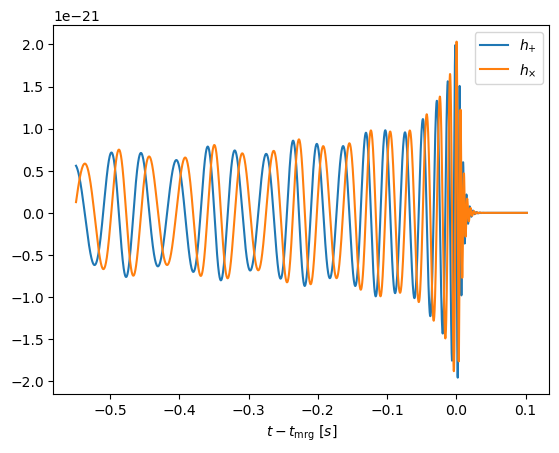

In [6]:
# Plot h
plt.plot(t, hp, label=r'$h_{+}$')
plt.plot(t, hc, label=r'$h_{\times}$')
#plt.xlim([0,0.05])
plt.xlabel(r'$t-t_{\rm mrg}$ $[s]$')
plt.legend()
plt.show()

# Match with other waveforms


In [7]:
# Finds next highest power of two
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

In [14]:
# Global params
f_low = 20
sample_rate = 4096

In [9]:
# PyCBC waveform
sp, sc = get_td_waveform(approximant="EccentricTD",
                         mass1=40,
                         mass2=20,
                         eccentricity=0.2,
                         f_ref=20,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

In [15]:
# TEOBResumS waveform
m1 = 40
m2 = 20
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 1,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : 0.2,
    'ecc_freq'           : 20,
    'output_hpc'         : 0,
}
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

The match is: 0.4017


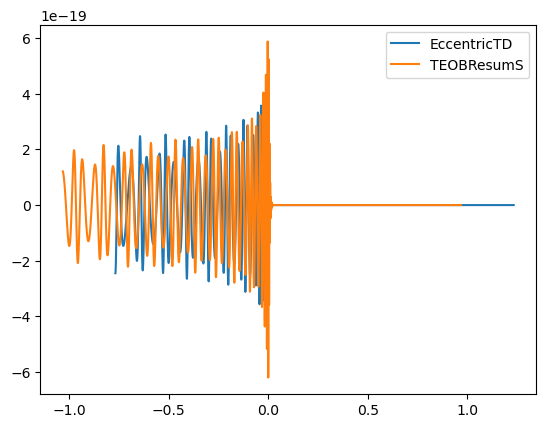

In [11]:
# Resize the waveforms to the same length
tlen = ceiltwo(max(len(sp), len(hp)))
sp.resize(tlen)
hp.resize(tlen)
sc.resize(tlen)
hc.resize(tlen)

plt.plot(sp.sample_times, sp, label='EccentricTD')
plt.plot(hp.sample_times, hp, label='TEOBResumS')
plt.legend()
#plt.xlim(-1,0.1)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
print('The match is: {:.4f}'.format(m))

# Mass vs eccentricity

In [2]:
# Global params
f_low = 20
sample_rate = 4096

# Modes to use
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

# Finds next highest power of two
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

In [3]:
# Waveform to match to
m1 = 20
m2 = 10
ecc = 0.1
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'ecc_freq'           : 20,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

In [80]:
# Create grid of values
e_vals = np.linspace(0, 0.2, 31, endpoint=True)
M_vals = np.linspace(29, 31, 31, endpoint=True)
gridsize = len(e_vals)*len(M_vals)

# Calculate match for each point on grid
match_vals = []
progress = 0
for e in e_vals:
    match_vals.append([])
    for M in M_vals:
        
        # Create waveform to match
        pars.update({'M':M,'ecc':e})
        t, sp, sc = EOBRun_module.EOBRunPy(pars)
        s = sp - 1j*sc
        tmrg = t[np.argmax(np.abs(s))]
        t = t - tmrg
        sp = timeseries.TimeSeries(sp, np.mean(np.diff(t)), epoch=t[0])
        sc = timeseries.TimeSeries(sc, np.mean(np.diff(t)), epoch=t[0])
        
        # Resize the waveforms to the same length
        tlen = ceiltwo(max(len(sp), len(hp)))
        sp.resize(tlen)
        hp.resize(tlen)
        
        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration
        flen = tlen//2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        
        # Perform match
        m, _ = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
        match_vals[-1].append(m)
        progress += 1
        if progress%10 == 0 or progress == gridsize:
            print(f'{progress} done out of {gridsize}')

10 done out of 961
20 done out of 961
30 done out of 961
40 done out of 961
50 done out of 961
60 done out of 961
70 done out of 961
80 done out of 961
90 done out of 961
100 done out of 961
110 done out of 961
120 done out of 961
130 done out of 961
140 done out of 961
150 done out of 961
160 done out of 961
170 done out of 961
180 done out of 961
190 done out of 961
200 done out of 961
210 done out of 961
220 done out of 961
230 done out of 961
240 done out of 961
250 done out of 961
260 done out of 961
270 done out of 961
280 done out of 961
290 done out of 961
300 done out of 961
310 done out of 961
320 done out of 961
330 done out of 961
340 done out of 961
350 done out of 961
360 done out of 961
370 done out of 961
380 done out of 961
390 done out of 961
400 done out of 961
410 done out of 961
420 done out of 961
430 done out of 961
440 done out of 961
450 done out of 961
460 done out of 961
470 done out of 961
480 done out of 961
490 done out of 961
500 done out of 961
510 done 

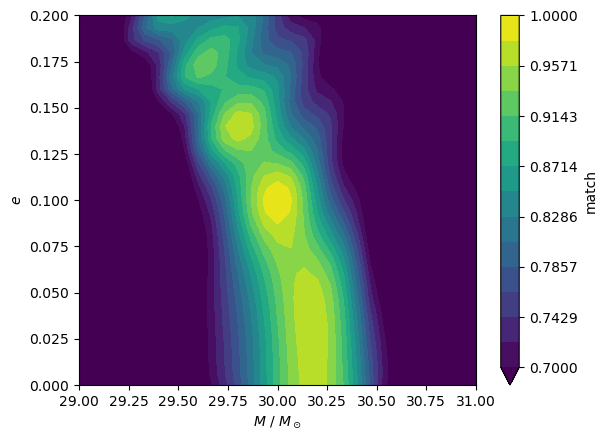

In [81]:
# Make contour plot
plt.contourf(M_vals, e_vals, match_vals, np.linspace(0.7, 1, 15), vmin=0.7, vmax=1, extend='min')
plt.xlabel('$M~/~M_\odot$')
plt.ylabel('$e$')
plt.colorbar(label='match')

## Fix oscillations

In [164]:
# Calculates component masses from total mass and mass ratio
def m1_m2_from_M_q(M, q):
    m2 = M/(1+q)
    m1 = M - m2
    return m1, m2

In [165]:
# Calculates orbital period from gw frequency
def P_from_f(f):
    f_orb = f/2
    return 1/f_orb

In [166]:
# Uses Kepler's 3rd to get semi-major axis from period of orbit
def a_from_P(P, M):
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

In [167]:
# Calculates periastron advance per orbital revolution
def peri_advance_orbit(P, e, M):
    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    
    return numerator/denominator

In [168]:
# Calculates number of orbits for true anomaly to shift by 2pi
def num_orbits(P, e, M):
    delta_phi = peri_advance_orbit(P, e, M)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

In [175]:
# How much frequency is shifted by per orbit
def delta_freq_orbit(P, e, M, q):
    m1, m2 = m1_m2_from_M_q(M, q)
    numerator = 192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**2*P**(11/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

In [176]:
# Calculates what new shifted frequency should be
def shifted_f(f, e, M, q):
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit(P, e, M, q)
    n_orbit = num_orbits(P, e, M)
    return f - delta_f_orbit*n_orbit

In [177]:
# Calculates what new shifted frequency and eccentricity should be
def shifted_params(f, e, M, q):
    M *= aconst.M_sun.value # Converts from solar masses to SI units
    f_new = shifted_f(f, e, M, q)
    e_new = e*(f_new/f)**(-19/18)
    return f_new, e_new

In [178]:
shifted_params(20, 0.1, 80, 2)

/local/ben.patterson/ipykernel_255490/1999638217.py:5: RuntimeWarning: invalid value encountered in scalar power
  e_new = e*(f_new/f)**(-19/18)


(-2.1835118790811114e+26, nan)

In [179]:
P = P_from_f(20)
print(P)
a = a_from_P(P, 80*aconst.M_sun.value)
print(a)
n = num_orbits(P, 0.1, 80*aconst.M_sun.value)
print(n)
delta_f_orbit = delta_freq_orbit(P, 0.1, 80*aconst.M_sun.value, 2)
print(delta_f_orbit)

0.1
1390637.5801068547
1.3466455336095482
1.6214451573076003e+26
